In [1]:
import numpy as np
from PIL import Image
import glob

> #### 이전 까지는 해상도를 평균값으로 했다.
> #### 이렇게 되면 데이터가 손실되는 이미지가 생기기 떄문에 최대 해상도로 맞추는 것이 맞다.

---
### 전체 사진중 최대 해상도 찾기

In [2]:
dirNames = ['Aiden','Andrew','Cathy']

In [3]:
width = []
height = []

for i in dirNames:
    for file in sorted(glob.glob(f'./Data/Face/{i}/*.jpg')):
        img = Image.open(file)
        img = np.array(img,dtype=np.int32)
        width.append(img.shape[1])
        height.append(img.shape[0])

print('max width :',np.max(width),', max height :' , np.max(height))

max width : 299 , max height : 381


### 이미지 센터에 맞추기
- height : 400 , width : 300 인 이미지로 resize 하자. <br><br>
- 하지만 이 때 이것보다 작은 이미지들을 이 사이즈에 넣게 되면 여백이 생기게 된다. <br><br>
- 따로 조정을 하지 않으면 작은 이미지들을 고정 사이즈로 바꾸게 되면 왼쪽 위에 붙게 되므로 이를 센터에 오게끔 하는 작업이 필요하다. <br><br>

In [4]:
# 전체 fileName 가져오기
for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob(f'./Data/Face/{name}/*.jpg')):
        img = Image.open(file)
        imgResize = img.convert('L') # gray color 바꾸기
        imgArray = np.array(imgResize)
        
        # 400, 300 짜리 이미지 사이즈 만들기
        imgDummy = np.zeros(400 * 300).reshape(400,300)
        
        rowNum = (400 - imgArray.shape[0]) / 2
        columnNum = (300 - imgArray.shape[1]) / 2

        # imgDummy에 넣기
        k = 0
        for i in list( range(int(rowNum) , int(rowNum) + imgArray.shape[0])):
            l = 0
            for j in list( range(int(columnNum) , int(columnNum) + imgArray.shape[1])):
                imgDummy[i,j] = imgArray[k,l]
                l += 1
            k += 1
        
        img2 = Image.fromarray(imgDummy.astype('uint8'),'L')
        img2.save('./Data/FaceGray/%s/image_%04d.jpg'%(name,fileCount),'JPEG')
        fileCount += 1

---
### FaceGray 이미지 가져오기

In [5]:
X = []
y = []

In [6]:
target = 0
i = 0
train  = np.zeros(54 * 300 * 400,dtype = np.int32).reshape(54,400,300)
for name in dirNames:
    
    for file in sorted(glob.glob(f'./Data/FaceGray/{name}/*.jpg')):
        img = Image.open(file)
        train[i] = np.array(img , dtype = np.int32)
        y.append(target)
        i += 1

    target += 1

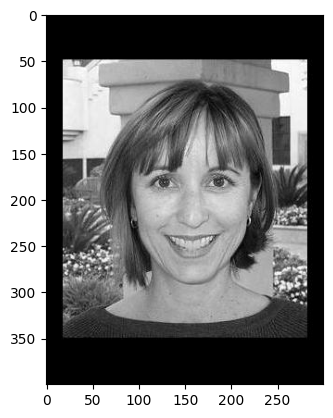

2


In [7]:
import matplotlib.pyplot as plt

plt.imshow(train[37], cmap='gray')

plt.show()

print(y[37])

In [8]:
# plt.figure(figsize=(20,20))
# orderNo = list(range(0,len(dirNames)*18 , 18))
# for i in list(range(1,len(dirNames)+1)):
#     plt.subplot(1,len(dirNames),i)
#     plt.imshow(train[orderNo[i-1]].reshape(400,300),cmap='gray')
    

### CNN 해보기

In [9]:
target = np.array(y.copy() ,dtype = np.int32)

In [10]:
train_scaled = train.reshape(-1,400,300,1) / 255.0

In [11]:
train_scaled.shape
target.shape

(54,)

In [12]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled , train_target , val_target = \
    train_test_split(train_scaled, target , test_size=0.2)

In [13]:
from tensorflow import keras

In [14]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(
    32,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same',
    input_shape = (400,300,1)
))

# pooling
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Conv2D(
    64,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same'
))

# pooling
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(3,activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 300, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 75, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 100)               4

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./Data/face-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

hist = model.fit(train_scaled,
                 train_target,
                 epochs=20,
                 validation_data = (val_scaled,val_target),
                 callbacks=[checkpoint_cb]
                 )

Epoch 1/20


2023-03-03 14:38:44.669576: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 3s 920ms/step - loss: 2.8874 - accuracy: 0.3488 - val_loss: 7.6947 - val_accuracy: 0.3636
Epoch 2/20
2/2 [==============================] - 2s 793ms/step - loss: 6.4034 - accuracy: 0.4186 - val_loss: 0.7644 - val_accuracy: 0.9091
Epoch 3/20
2/2 [==============================] - 2s 857ms/step - loss: 0.5518 - accuracy: 0.8372 - val_loss: 0.9020 - val_accuracy: 0.8182
Epoch 4/20
2/2 [==============================] - 2s 826ms/step - loss: 0.7221 - accuracy: 0.7907 - val_loss: 0.4799 - val_accuracy: 0.9091
Epoch 5/20
2/2 [==============================] - 2s 996ms/step - loss: 0.2397 - accuracy: 0.9535 - val_loss: 0.5054 - val_accuracy: 0.9091
Epoch 6/20
2/2 [==============================] - 2s 820ms/step - loss: 0.1202 - accuracy: 0.9767 - val_loss: 0.6858 - val_accuracy: 0.9091
Epoch 7/20
2/2 [==============================] - 2s 904ms/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.7150 - val_accuracy: 0.9091
Epoch 8/20
2/2 [===============

In [17]:
model.evaluate(val_scaled,val_target)

1/1 [==============================] - 0s 185ms/step - loss: 1.1824 - accuracy: 0.9091


[1.1823744773864746, 0.9090909361839294]

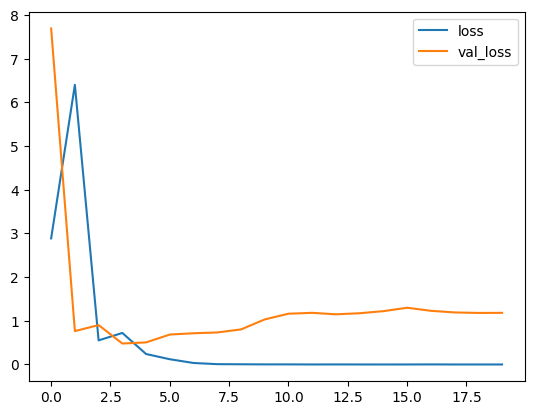

In [18]:
plt.plot(
    hist.history['loss'],
    label = 'loss'
)

plt.plot(
    hist.history['val_loss'],
    label = 'val_loss'
)

plt.legend()

plt.show()

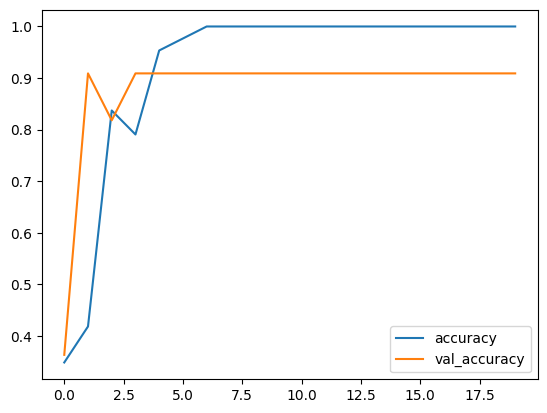

In [19]:
plt.plot(
    hist.history['accuracy'],
    label = 'accuracy'
)

plt.plot(
    hist.history['val_accuracy'],
    label = 'val_accuracy'
)

plt.legend()

plt.show()